In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

import openslide
from openslide import deepzoom
import cv2 as cv
from PIL import Image, ImageDraw

In [2]:
project = "BRCA"
ik = 4
il = 0

In [3]:
i_slides_train_valid_test = np.load("../16patients_split/i_slides_nested_%s.npz"%project, allow_pickle=True)
i_slides_test = i_slides_train_valid_test["i_slides_test"][ik]
#print(i_slides_test)

#i_slide = i_slides_test[0]
#print("i_slide:", i_slide)

In [8]:
## load tile information and tile score:
tile = np.load("../12tiles_from_slide/tiles_selected/tiles_selected_npy/%s_tiles_selected.npy"%project, allow_pickle=True)

tile_scores = np.load("tile_scores_%s_ik%s_il%s.npy"%(project, ik, il), allow_pickle=True)

### gene names
best_genes = np.loadtxt("220Nov21BRCA_nonrot_ik4_il0/R_sorted.txt", dtype="str")
best_genes = best_genes[:,2]
#print("best_genes:", best_genes)
genes = np.loadtxt("../15select_genes/%s_gene_active90_mediansorted_names.txt"%project, dtype="str")
genes = genes[:,5]
i_genes = np.array([np.argwhere(genes == best_gene)[0][0] for best_gene in best_genes])

i_genes = i_genes[:5]

In [11]:
i_slide = 346

#for i_slide in i_slides_test[:80]:

### Load tile_selected information
n_slides = len(tile)
print("n_slides:", n_slides)

i_slides = np.array([tile[i][0] for i in range(n_slides)])
#print("i_slides:", i_slides)

i0 = np.argwhere(i_slides == i_slide)[0][0]
print("i0:", i0)

slide_name = tile[i0][1]
print("slide_name:", slide_name)

slide_level = tile[i0][2]
print("slide_level:", slide_level)

idx_row_col = tile[i0][3]
print("idx_row_col.shape:", idx_row_col.shape)
#print(idx_row_col)

##------------------------------------
### Load tile_score
n_slides = len(tile_scores)
print("n_slides:", n_slides)

i_slides = np.array([tile_scores[i][0] for i in range(n_slides)])
#print("i_slides:", i_slides)

i0 = np.argwhere(i_slides == i_slide)[0][0]
print("i0:", i0)

print("i_slide:", tile_scores[i0][0])
print("slide_name:", tile_scores[i0][1])
scores = tile_scores[i0][2]
print("scores.shape", scores.shape)


### Load image
##------------------------------------
tile_size = 512
mask_downsampling = 16
magnification = 20

path2slides = "../%s_slides_data_test"%project

slide = openslide.OpenSlide("%s/%s.svs"%(path2slides, slide_name))

## magnification max
if openslide.PROPERTY_NAME_OBJECTIVE_POWER in slide.properties:
    magnification_max = slide.properties[openslide.PROPERTY_NAME_OBJECTIVE_POWER]
else:
    print('[WARNING] openslide.PROPERTY_NAME_OBJECTIVE_POWER was not found. Assuming it is 40X, i_slide:', i_slide)
    magnification_max = 40

#print("magnification_max:", magnification_max)

## downsample_level
downsampling = int(int(magnification_max)/magnification)
print("downsampling:", downsampling)

##------------------------------------

slide_gen = deepzoom.DeepZoomGenerator(slide, tile_size=tile_size, overlap=0)
slide_gen_selectedlevel_idx = slide_level
print("slide_gen_selectedlevel_idx:", slide_gen_selectedlevel_idx)

slide_gen_selectedlevel_dims = slide_gen.level_dimensions[slide_gen_selectedlevel_idx]
print("slide_gen_selectedlevel_dims:", slide_gen_selectedlevel_dims)

### Downsampling
best_downsampling_level = slide.get_best_level_for_downsample(mask_downsampling + 0.1)
print("best_downsampling_level:", best_downsampling_level)
print("slide.level_dimensions[best_downsampling_level]:", slide.level_dimensions[best_downsampling_level])

# image at the best level
img_best_level = slide.read_region((0, 0), best_downsampling_level, 
                           slide.level_dimensions[best_downsampling_level])
print(img_best_level.size)

target_size = tuple([int(x//mask_downsampling) for x in slide.dimensions])
print("target_size:", target_size)

## resize the image to the target size
img = img_best_level.resize(target_size)
print("img.size:",img.size)
#plt.imshow(img)

## remove the alpha channel and convert to numpy
#img_RGB = np.array(img.convert("RGB"))
#print("img.shape - RGB:", img_RGB.shape)
#plt.imshow(img_RGB)

mask_tile_size = int(np.ceil(tile_size*(downsampling/mask_downsampling)))
print("mask_tile_size:", mask_tile_size)

n_slides: 1033
i0: 333
slide_name: BRCA_00346_558a3a47-68a7-4e87-ac3a-434c06d0b114
slide_level: 16
idx_row_col.shape: (3402, 3)
n_slides: 206
i0: 72
i_slide: 346
slide_name: BRCA_00346_558a3a47-68a7-4e87-ac3a-434c06d0b114
scores.shape (3402, 22884)
downsampling: 1
slide_gen_selectedlevel_idx: 16
slide_gen_selectedlevel_dims: (49408, 64256)
best_downsampling_level: 2
slide.level_dimensions[best_downsampling_level]: (3088, 4016)
(3088, 4016)
target_size: (3088, 4016)
img.size: (3088, 4016)
mask_tile_size: 32


In [14]:
i_genes

array([ 4360,   256,  2480, 15884,  2107])

In [19]:
i_gene = i_genes[2]
i_gene

2480

heatmap.shape (4016, 3088)
--- completed i_slide ---: 346


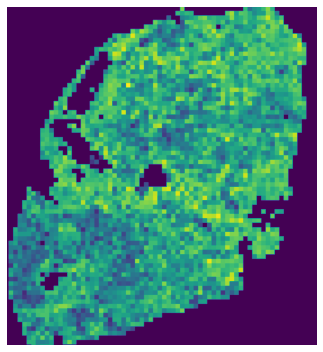

In [20]:
##----------------------------------------------------------
heatmap = np.zeros((img.size[1], img.size[0]))
print("heatmap.shape", heatmap.shape)

rows = idx_row_col[:,1]
cols = idx_row_col[:,2]

##----------------------------------------------------------
nx,ny = 1,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*4.6,ny*6))

#ax.imshow(img)

#for iax, i_gene in enumerate(i_genes):
score = scores[:,i_gene]
score = score - score.min()

#     #print("score.shape:", score.shape)

for i in range(len(rows)):
    heatmap[int(rows[i]*mask_tile_size):int((rows[i]+1)*mask_tile_size), 
        int(cols[i]*mask_tile_size):int((cols[i]+1)*mask_tile_size)] = score[i]

ax.imshow(heatmap[100:2500,500:2700])
#     #plt.clim(0,3)

for i in range(nx):
    ax.axis('off')
    
#plt.colorbar(im,ax=ax[1],fraction=0.045, pad=0.05,ticks=[-1.0,0,1.0])

plt.tight_layout(h_pad=1, w_pad= 0.5)
plt.savefig("heatmap_slide%s_gene3.pdf"%(i_slide), format='pdf', dpi=50, bbox_inches='tight')
#plt.close()

print("--- completed i_slide ---:", i_slide)